In [1]:
import pickle
import sys

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

from src.cfd import CFD
from src.dataset import X_TIME, TIME_STEP
from src.gauss_hist import get_gauss_stats
from src.models import optimal_model_builder_all_ch
from src.network_utils import train_model as _base_train_model, plot_difference_hist, plot_history, compare_results, \
    gaussian_kernel

PWD = '../../../..'
sys.path.append(PWD)

tf.get_logger().setLevel('ERROR')

In [2]:
N_JOBS = 16

DATASET_PATH = PWD + '/data/dataset/dataset_r354332.pkl'

PRINT_PCOV = False

N_BASELINE = 6

BATCH_SIZE = 8192
LOSS_WEIGHT = 1000

CFD_THRESHOLD_SPACE = np.arange(0.10, 0.20, 0.005)
OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH = PWD + '/data/tmp/many_channels_tests/optimal_cfd_thresholds_r354332.pkl'

TRAIN_TEST_SPLIT_RANDOM_STATE = 42
TEST_SIZE = 0.2

In [3]:
with open(DATASET_PATH, 'rb') as file:
    dataset = pickle.load(file)

# Utils

In [4]:
def model_predict(model: tf.keras.Model, X: np.ndarray):
    Y_heatmap_pred = model.predict(X, batch_size=4096)

    y_pred = np.empty(Y_heatmap_pred.shape[0])
    for i, y in enumerate(Y_heatmap_pred):
        _, y_pred[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

    return y_pred

In [5]:
def train_model(model, name, train=False, verbose=1, batch_size=BATCH_SIZE, loss_weights=LOSS_WEIGHT):
    return _base_train_model(model, name, 'many_channels_tests/trained_on_all', [], [], [], [], 0.01,
                             train, 1, verbose, batch_size, 1, 1, 1, loss_weights, root=PWD + '/data')

# Optimal CFD thresholds

In [6]:
from src.cfd import find_optimal_cfd_threshold

optimal_cfd_thresholds = {}
for plane, channel in sorted(dataset.keys()):
    print(f'Processing p={plane}, ch={channel}...')
    all_X, all_y = dataset[(plane, channel)][0], dataset[(plane, channel)][1]
    X_train, _, y_train, _ = train_test_split(all_X, all_y, test_size=0.25, random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)

    optimal_cfd_threshold = find_optimal_cfd_threshold(CFD_THRESHOLD_SPACE, N_BASELINE, X_train, y_train, X_TIME, n_jobs=N_JOBS, plot=False)
    optimal_cfd_thresholds[(plane, channel)] = optimal_cfd_threshold

with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'wb') as file:
    pickle.dump(optimal_cfd_thresholds, file)

Processing p=1, ch=2...
Optimal CFD threshold: 0.175
Processing p=1, ch=11...
Optimal CFD threshold: 0.175
Processing p=2, ch=2...
Optimal CFD threshold: 0.195
Processing p=2, ch=11...
Optimal CFD threshold: 0.145
Processing p=3, ch=2...
Optimal CFD threshold: 0.135
Processing p=3, ch=11...
Optimal CFD threshold: 0.145


In [7]:
with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'rb') as file:
    optimal_cfd_thresholds = pickle.load(file)

print('Optimal thresholds:')
for (plane, channel), threshold in optimal_cfd_thresholds.items():
    print(f'({plane:>1}, {channel:>2}): {threshold:0.3f}')

Optimal thresholds:
(1,  2): 0.175
(1, 11): 0.175
(2,  2): 0.195
(2, 11): 0.145
(3,  2): 0.135
(3, 11): 0.145


# Load the network

In [8]:
model = optimal_model_builder_all_ch()
history = train_model(model, "optimal")

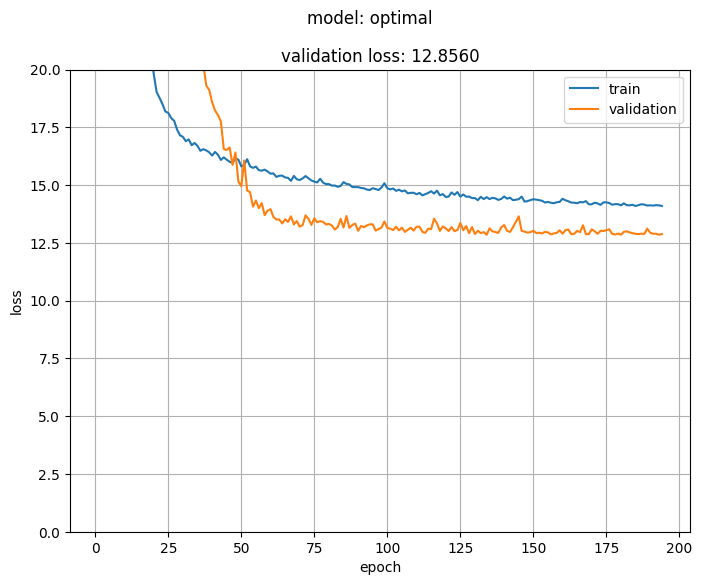

In [9]:
plot_history(history, f'model: optimal', ymax=20)

# Test

Processing p=1, ch=2...
1/1 [==============================] - 1s 679ms/step
       CFD: 85.57 ps
   optimal: 76.33 ps (improvement: 10.80 %)
Processing p=1, ch=11...
1/1 [==============================] - 0s 258ms/step
       CFD: 96.76 ps
   optimal: 84.95 ps (improvement: 12.20 %)
Processing p=2, ch=2...
1/1 [==============================] - 0s 219ms/step
       CFD: 91.05 ps
   optimal: 78.59 ps (improvement: 13.69 %)
Processing p=2, ch=11...
1/1 [==============================] - 0s 204ms/step
       CFD: 94.49 ps
   optimal: 86.69 ps (improvement: 8.25 %)
Processing p=3, ch=2...
1/1 [==============================] - 0s 219ms/step
       CFD: 99.40 ps
   optimal: 84.02 ps (improvement: 15.48 %)
Processing p=3, ch=11...
1/1 [==============================] - 0s 235ms/step
       CFD: 117.60 ps
   optimal: 102.50 ps (improvement: 12.84 %)


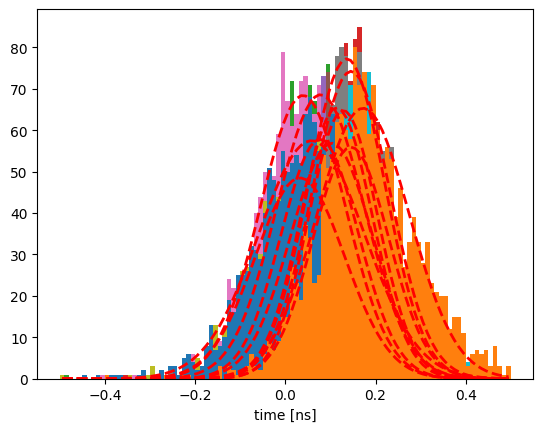

In [10]:
improvements = {}
for (plane, channel), (all_X, all_y) in dataset.items():
    print(f'Processing p={plane}, ch={channel}...')

    _, X_test, _, y_test = train_test_split(all_X, all_y, test_size=0.25, random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)

    cfd = CFD(n_baseline=N_BASELINE, threshold=optimal_cfd_thresholds[(plane, channel)])
    y_pred_cfd = cfd.predict(X_TIME, X_test)
    std_cfd, _, _ = plot_difference_hist(y_test, y_pred_cfd, show=False, close=False)

    y_pred_model = model_predict(model, X_test)
    std_model, _, _ = plot_difference_hist(y_test, y_pred_model, show=False, close=False)

    compare_results([std_model], ["optimal"], std_cfd)
    improvements[(plane, channel)] = (std_cfd, std_model, 1 - std_model / std_cfd)

In [11]:
print('Improvements:')
for (plane, channel), improv in improvements.items():
    print(
        f'({plane:>1}, {channel:>2}) CFD: {improv[0] * 1000:6.2f} ps, NN: {improv[1] * 1000:6.2f} ({improv[2] * 100:5.2f} %)')

Improvements:
(1,  2) CFD:  85.57 ps, NN:  76.33 (10.80 %)
(1, 11) CFD:  96.76 ps, NN:  84.95 (12.20 %)
(2,  2) CFD:  91.05 ps, NN:  78.59 (13.69 %)
(2, 11) CFD:  94.49 ps, NN:  86.69 ( 8.25 %)
(3,  2) CFD:  99.40 ps, NN:  84.02 (15.48 %)
(3, 11) CFD: 117.60 ps, NN: 102.50 (12.84 %)
